## 1. 단순 선형 회귀 
- LinearRegression을 이용해 boston 주택가격 회귀 구현

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
%matplotlib inline

boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)

boston_df['PRICE'] = boston.target
boston_df.shape
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
PRICE      506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


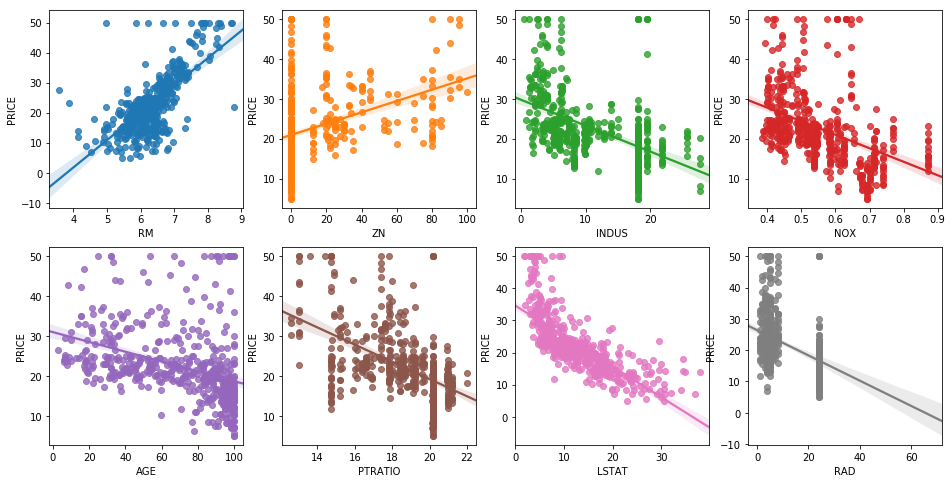

In [6]:
# 각 칼럼이 회귀결과에 미치는 영향을 확인

flg, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # regplot을 이용해 산점도와 선형회귀 직선을 함께 표현
    sns.regplot(x=feature, y='PRICE', data=boston_df, ax=axs[row][col])

RM과 LSTAT의 영향도가 가장 두드러지게 나타남
- RM(방의 크기)은 양방향의 선형성이 가장 크다. 
- LSTAT(하위 계층의 비율)은 음 방향의 선형성이 가장 크다. 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = boston_df['PRICE']
x_data = boston_df.drop(['PRICE'], axis=1, inplace=False)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_target, test_size=0.3, random_state=156)

선형회귀 OLS로 학습/예측/평가 수행

In [8]:
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('mse : {0:.3f}, rmse : {1:.3f}'.format(mse, rmse))
print('variance score: {0:.3f}'.format(r2_score(y_test, y_pred)))

mse : 17.297, rmse : 4.159
variance score: 0.757


In [9]:
print('절편 값: ', lr.intercept_)

# 각 컬럼의 선형회귀 계수값
coeff = pd.Series(data=np.round(lr.coef_, 1), index = x_data.columns)
coeff.sort_values(ascending=False)

절편 값:  40.99559517216454


RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [10]:
# 교차 검증으로 MSE와 RMSE 측정

from sklearn.model_selection import cross_val_score

y_target = boston_df['PRICE']
x_data = boston_df.drop(['PRICE'],axis=1, inplace = False)
lr = LinearRegression()

neg_mse_scores = cross_val_score(lr, x_data, y_target, scoring='neg_mean_squared_error',cv =5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_scores(scoring='neg_mean_squres_error') 로 반환된 값은 모두 음수
print('5folds의 개별 negative MSE scores: ', np.round(neg_mse_scores,2))
print('5folds의 개별 RMSE scores: ',np.round(rmse_scores,2))
print('5folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5folds의 개별 negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
5folds의 개별 RMSE scores:  [3.53 5.1  5.75 8.99 5.77]
5folds의 평균 RMSE : 5.829


## 2.  다항 회귀
- 다항회귀는 선형회귀!
- sklearn은 다항회귀를 위한 클래스를 제공하지 않음.
- -> 다중 회귀모델을 통해 구현한다.
### 다항회귀 모델 구현 방법:  비선형 함수를 선형 모델에 적용
- 다항 회귀를 적용하여 다중회귀 모델로 계산
        1) PolynomialFeatures 클래스를 이용해 단항식 계수를 다항식 계수로 변환
        2) LinearRegression() 선형회귀를 이용해 학습,예측을 수행

In [11]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

x=np.arange(4).reshape(2,2)
print('일차 단항식 계수 피처: \n',x)

# 1) PolynomialFeatures(degree=2) 를 통해 2차 다항식으로 변환.
poly = PolynomialFeatures(degree=2)
poly_ftr = poly.fit_transform(x)
print('변환된 2차 다항식 계수 피처: \n',poly_ftr)

# 2) 비선형 함수를 선형 모델에 적용

일차 단항식 계수 피처: 
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 피처: 
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


- 임의의 원하는 3차 다항식을 통해 회귀 계수를 예측

In [29]:
# 3차 다항 회귀 함수 생성
def polynomial_func(x):
    y = 1 + 2*x[:,0] + 3*x[:,0]**2 + 4*x[:,1]**3
    return y

x = np.arange(4).reshape(2,2)
print('일차 단항식 계수 feature: \n',x)

y = polynomial_func(x)
print('3차 다항식 결정값', y)

일차 단항식 계수 feature: 
 [[0 1]
 [2 3]]
3차 다항식 결정값 [  5 125]


In [30]:
# 1) 다항식으로 변환
poly_ftr = PolynomialFeatures(degree=3).fit_transform(x)
print('3차 다항식 계수feature: \n',poly_ftr)

# 2) linear_regression 선형회귀 예측
model = LinearRegression()
model.fit(poly_ftr, y)
print('Polynomial 회귀계수 \n', np.round(model.coef_,2))
print('Polynomial 회귀 shape : ',model.coef_.shape)

3차 다항식 계수feature: 
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀계수 
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 shape :  (10,)


In [31]:
# 위의 과정을 pipeline을 통해 한번에 구현

from sklearn.pipeline import Pipeline

model = Pipeline([('poly',PolynomialFeatures(degree=3)),
                 ('linear',LinearRegression())])
x = np.arange(4).reshape(2,2)
y = polynomial_func(x)

model = model.fit(x,y)
print('Polynomial 회귀 계수 \n',np.round(model.named_steps['linear'].coef_,2))

Polynomial 회귀 계수 
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


- 다항회귀 예측

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 실제 값
def true_func(x):
    return np.cos(1.5 * np.pi * x)

# 0~1 까지 30개의 임의의 값을 순서대로 샘플링
np.random.seed(0)
n_samples=30
x = np.sort(np.random.rand(n_samples))

y = true_func(x) + np.random.randn(n_samples) * 0.1 #약간의 노이즈 변동값을 더함

In [69]:
poly = PolynomialFeatures(degree=4, include_bias = False)
lr = LinearRegression()
pipeline = Pipeline([("polynomial_features", poly),
                     ("linear_regression",lr)])
pipeline.fit(x.reshape(-1, 1), y)

# 회귀 예측 수행
x_test = np.linspace(0,1, 100)

pred = pipeline.predict(x_test[:, np.newaxis])

coefficients = np.round(pipeline.named_steps['linear_regression'].coef_,2)

print('예측 값', pred[:10])
print('회귀 계수', coefficients)

예측 값 [1.03107515 1.03400696 1.03345345 1.02955778 1.02246132 1.0123036
 0.99922233 0.98335344 0.96483102 0.94378734]
회귀 계수 [  0.47 -17.79  23.59  -7.26]
회귀 계수 
 [  0.47 -17.79  23.59  -7.26]


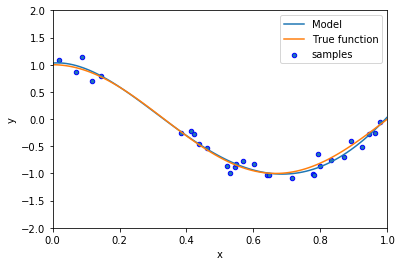

In [55]:
# 예측 곡선 그려보기

plt.figure()

# 예측값 곡선
plt.plot(x_test, pred ,label = "Model")

# 실제값 곡선
plt.plot(x_test, true_func(x_test), '-',label = 'True function')
plt.scatter(x, y, edgecolor='b', s=20, label = 'samples')

plt.xlabel('x'); plt.ylabel('y'); plt.xlim((0,1)); plt.ylim((-2,2)); plt.legend(loc='best')
#plt.title(degree {})
plt.show()

- 다항회귀의 과소적합, 과적합 이해
        - 다항식 차수를 1, 4, 15 로 변경해가면서 예측 결과를 비교


 degree 1 회귀계수는 [  0. -18.  24.  -7.]
degree 1 MSE는 0.043208749872317556

 degree 4 회귀계수는 [  0. -18.  24.  -7.]
degree 4 MSE는 0.043208749872317556

 degree 15 회귀계수는 [  0. -18.  24.  -7.]
degree 15 MSE는 0.043208749872317556


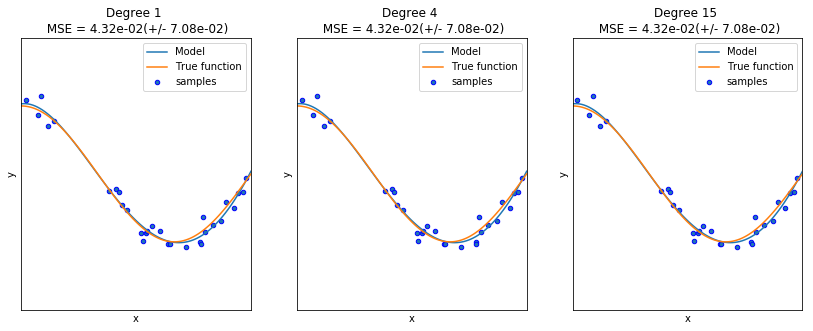

In [71]:
plt.figure(figsize=(14,5))
degrees =[1,4,15]

for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i+1)
    plt.setp(ax, xticks=(), yticks =())
    
    # 개별 degree별로 polynomial 변환
    poly = PolynomialFeatures(degree=4, include_bias = False)
    lr = LinearRegression()
    pipeline = Pipeline([("polynomial_features", poly),
                         ("linear_regression",lr)])
    pipeline.fit(x.reshape(-1, 1), y)

    # 교차 검증으로 다항회귀를 평가
    scores = cross_val_score(pipeline, x.reshape(-1,1), y, scoring = 'neg_mean_squared_error', cv=10)
    
    # 회귀 계수 추출
    coefficients = np.round(pipeline.named_steps['linear_regression'].coef_)
    print('\n degree {0} 회귀계수는 {1}'.format(degrees[i], np.round(coefficients), 2))
    print('degree {0} MSE는 {1}'.format(degrees[i], -1*np.mean(scores)))
    
    # 테스트 데이터를 100개로 나눠 예측 수행
    x_test = np.linspace(0,1, 100)

    # 예측값 곡선
    plt.plot(x_test, pipeline.predict(x_test[:, np.newaxis]) ,label = "Model")

    # 실제값 곡선
    plt.plot(x_test, true_func(x_test), '-',label = 'True function')
    plt.scatter(x, y, edgecolor='b', s=20, label = 'samples')

    plt.xlabel('x'); plt.ylabel('y'); plt.xlim((0,1)); plt.ylim((-2,2)); plt.legend(loc='best')
    plt.title('Degree {} \n MSE = {:.2e}(+/- {:.2e})'.format(degrees[i], -scores.mean(), scores.std()))
    
plt.show()